## Improved Model 

In [170]:
# Import libraries

import warnings
warnings.filterwarnings('ignore')

from keras import models, layers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [171]:
# load MNIST dataset

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [172]:
# reshape for tenserflow backend
reshaped_train_images = train_images.reshape((60000, 28, 28, 1))
reshaped_test_images = test_images.reshape((10000, 28, 28, 1))

# rescale pixel values from range [0, 255] to [0, 1]
rescaled_train_images= reshaped_train_images.astype('float32') / 255. 
rescaled_test_images= reshaped_test_images.astype('float32') / 255.

# converts a class vector (integers) to binary class matrix
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

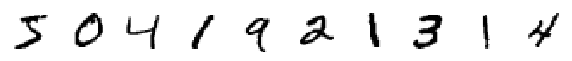

In [173]:
# show sample train images without noise
_, ax = plt.subplots(1, 10, figsize=(10,10))

for i in range(0, 10):
    ax[i].axis('off')
    ax[i].imshow(rescaled_train_images[i].reshape(28,28), cmap=plt.cm.binary)

In [174]:
# add noise to training and test dataset

noise_factor = 0.1

train_images_noisy = rescaled_train_images + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=rescaled_train_images.shape)
test_images_noisy = rescaled_test_images + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=rescaled_test_images.shape)
train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

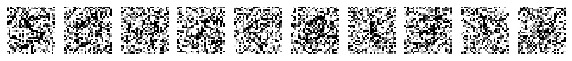

In [175]:
# show sample train images with noise
_, ax = plt.subplots(1, 10, figsize=(10,10))

for i in range(0, 10):
    ax[i].axis('off')
    ax[i].imshow(train_images_noisy[i].reshape(28,28), cmap=plt.cm.binary)

## Adding Denoising Convolutional Autoencoder

In [177]:
input_img = Input(shape=(28, 28, 1))

# encoder

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# decoder

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Train the autoencoder model
autoencoder.fit(train_images_noisy, rescaled_train_images,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 67s 1ms/step - loss: 0.1688 - val_loss: 0.1680
Epoch 2/10
48000/48000 [==============================] - 65s 1ms/step - loss: 0.1664 - val_loss: 0.1679
Epoch 3/10
48000/48000 [==============================] - 68s 1ms/step - loss: 0.1650 - val_loss: 0.1657
Epoch 4/10
48000/48000 [==============================] - 65s 1ms/step - loss: 0.1638 - val_loss: 0.1647
Epoch 5/10
18624/48000 [==========>...................] - ETA: 36s - loss: 0.1632

In [179]:
# get decoded training and test images

decoded_train_imgs = autoencoder.predict(train_images_noisy)
decoded_test_imgs = autoencoder.predict(test_images_noisy)

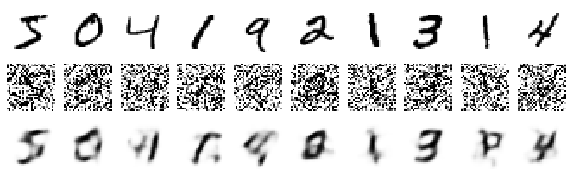

In [180]:
# show sample train images without noise, train images with noice and decoded train images
_, ax = plt.subplots(3, 10, figsize=(10,3))

for i in range(0, 10):
    ax[0,i].axis('off')
    ax[0,i].imshow(train_images[i].reshape(28,28), cmap=plt.cm.binary)
    ax[1,i].axis('off')
    ax[1,i].imshow(train_images_noisy[i].reshape(28,28), cmap=plt.cm.binary)
    ax[2,i].axis('off')
    ax[2,i].imshow(decoded_train_imgs[i].reshape(28,28), cmap=plt.cm.binary)

In [159]:
# get test set
final_test_labels = test_labels
final_test_images = decoded_test_imgs

# get validation set
validation_images = decoded_train_imgs[50000:]
validation_labels = train_labels[50000:]

# get train set
final_train_images = decoded_train_imgs[:50000]
final_train_labels = train_labels[:50000]

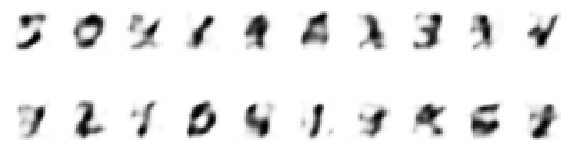

In [154]:
# show sample final_train_images and final_test_images
_, ax = plt.subplots(2, 10, figsize=(10,3))

for i in range(0, 10):
    ax[0,i].axis('off')
    ax[0,i].imshow(final_train_images[i].reshape(28,28), cmap=plt.cm.binary)
    ax[1,i].axis('off')
    ax[1,i].imshow(final_test_images[i].reshape(28,28), cmap=plt.cm.binary)

In [161]:
final_test_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [155]:
# function to build a CNN model

def create_model():
    # Convolutional model
    model = models.Sequential()

    # Conv Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    
    # Pool Layer 1
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Pool Layer 2
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Layer 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Flatten Layer 1
    model.add(layers.Flatten())

    # Fully-connected layer 1
    model.add(layers.Dense(64, activation='relu'))
    
    # Fully-connected layer 2
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [156]:
# build a model
model = create_model()

In [157]:
# Train the model
model.fit(final_train_images, final_train_labels, epochs=5, batch_size=64, validation_data=(validation_images, validation_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 21s 414us/step - loss: 0.9975 - accuracy: 0.6603 - val_loss: 0.8082 - val_accuracy: 0.7281
Epoch 2/5
50000/50000 [==============================] - 22s 440us/step - loss: 0.7941 - accuracy: 0.7281 - val_loss: 0.8092 - val_accuracy: 0.7298
Epoch 3/5
50000/50000 [==============================] - 21s 423us/step - loss: 0.7455 - accuracy: 0.7462 - val_loss: 0.7589 - val_accuracy: 0.7412
Epoch 4/5
50000/50000 [==============================] - 21s 411us/step - loss: 0.7134 - accuracy: 0.7570 - val_loss: 0.7199 - val_accuracy: 0.7582
Epoch 5/5
50000/50000 [==============================] - 22s 439us/step - loss: 0.6892 - accuracy: 0.7646 - val_loss: 0.7192 - val_accuracy: 0.7576


In [160]:
# get accuracy against test set

test_loss, test_acc = improved_model.evaluate(final_test_images, final_test_labels, verbose=1)
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

10000/10000 [==============================] - 2s 164us/step
Accuracy: 0.1111999973654747
Loss:  57.6099116027832
